This notebook allows you to visualize exploration and exploitation statistics for the Exploration in Malmo Continuous Mountain Cart EMC^2 experiment. make sure your data is in the run_saves/ folder.

In [18]:
import numpy as np
import os
import pylab
import seaborn
import scipy.stats as sp
import pickle
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import distance
import json
from collections import OrderedDict
import os.path as osp
import pandas as pd
import copy
import scipy.stats as ss
DIV_LINE_WIDTH = 50

In [19]:
# Global vars for tracking and labeling data at load time.
exp_idx = 0
units = dict()

def get_all_runs(logdir, condition=None):
    #print(logdir)
    """
    Recursively look through logdir for output files produced by
    spinup.logx.Logger. 

    Assumes that any file "progress.txt" is a valid hit. 
    """
    global exp_idx
    global units
    datasets = []
    for root, _, files in os.walk(logdir):
        #print(root)
        if 'progress.txt' in files:
            print(root)
            exp_name = None
            try:
                config_path = open(os.path.join(root,'config.json'))
                config = json.load(config_path)
                if 'exp_name' in config:
                    exp_name = config['exp_name']
                    
            except:
                print('No file named config.json')
            condition1 = condition or exp_name or 'exp'
            condition2 = condition1 + '-' + str(exp_idx)
            exp_idx += 1
            if condition1 not in units:
                units[condition1] = 0
            unit = units[condition1]
            units[condition1] += 1

            exp_data = pd.read_table(os.path.join(root,'progress.txt'))
            performance = 'AverageTestEpRet' if 'AverageTestEpRet' in exp_data else 'AverageEpRet'
            exp_data.insert(len(exp_data.columns),'Unit',unit)
            exp_data.insert(len(exp_data.columns),'Condition1',condition1)
            exp_data.insert(len(exp_data.columns),'Condition2',condition2)
            exp_data.insert(len(exp_data.columns),'evaluation return',exp_data[performance])
            data_dict = exp_data.to_dict("list")
            data_dict['total timesteps'] = []
            for e in data_dict['Epoch']:
                data_dict['total timesteps'].append(e * config['steps_per_epoch'])
            data_dict['config'] = config
            #print(config)
                
            nb_epochs = len(data_dict['total timesteps'])
            print(nb_epochs)
            datasets.append(data_dict)
            
            if 'env_params_save.pkl' in files:
                env_params_dict = pickle.load( open(os.path.join(root,'env_params_save.pkl'), "rb" ) )
                for k,v in env_params_dict.items():
                    data_dict[k] = v
    print(datasets[-1]['config']['exp_name'])
    return datasets

def get_datasets(rootdir="data/data_to_vizu/"):
    default_colors = ["r",u'#1f77b4','green','black',u'#ff7f0e',"violet","cyan"]
    _, models_list, _ = next(os.walk(rootdir))
    print(models_list)
    for i,m_name in enumerate(models_list):
        colors[m_name] = default_colors[i]
        m_id = m_name
        models_saves[m_id] = OrderedDict()
        models_saves[m_id]['data'] = get_all_runs(rootdir+m_name)

    """
    retrieve all experiences located in "data to vizu" folder
    """

labels = {'sac_lgwidestumpnoinputlevels':'SAC+Random Env',
         'sagg_sac2':"SAC+SAGG_IAC",
         'sac_wstumpnoinputlvls_oracle4':"SAC+Linear Oracle"}
models_saves = OrderedDict()
colors = OrderedDict()
get_datasets()


['sagg_cont', 'oracle_cont']
data/data_to_vizu/sagg_cont/sagg_cont_s50
198
data/data_to_vizu/sagg_cont/sagg_cont_s30
193
data/data_to_vizu/sagg_cont/sagg_cont_s40
194
data/data_to_vizu/sagg_cont/sagg_cont_s0
196


/home/remy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


data/data_to_vizu/sagg_cont/sagg_cont_s10
193
data/data_to_vizu/sagg_cont/sagg_cont_s20
195
sagg_cont
data/data_to_vizu/oracle_cont/oracle_cont_s33
208
data/data_to_vizu/oracle_cont/oracle_cont_s55
207
data/data_to_vizu/oracle_cont/oracle_cont_s10
205
data/data_to_vizu/oracle_cont/oracle_cont_s30
205
data/data_to_vizu/oracle_cont/oracle_cont_s11
203
data/data_to_vizu/oracle_cont/oracle_cont_s12
205
data/data_to_vizu/oracle_cont/oracle_cont_s50
206
data/data_to_vizu/oracle_cont/oracle_cont_s0
205
data/data_to_vizu/oracle_cont/oracle_cont_s13
204
data/data_to_vizu/oracle_cont/oracle_cont_s40
204
data/data_to_vizu/oracle_cont/oracle_cont_s20
200
data/data_to_vizu/oracle_cont/oracle_cont_s44
199
oracle_cont


In [ ]:
print(list(models_saves))
#print([len(models_saves['SAC']['data'][i]['Epoch']) for i  in range(len(models_saves['SAC']['data']))])

In [26]:
def plot_with_std(subplot_nb, ax,x,y,err,color,shade_color,label,
                  y_min=None,y_max=None, legend=False, title=None):
    #plt.rcParams.update({'font.size': 15})
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    ax.plot(x,y, color=color, label=label,linewidth=1.5)
    ax.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=16)
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)
    ax.set_xlabel('iterations', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('Exploration %', fontsize=18)
    ax.set_xlim(xmin=min(x),xmax=28000000)
    if y_min is not None:
        ax.set_ylim(bottom=y_min,top=y_max)
    if title:
        ax.set_title(title, fontsize=22)

def plot_all_and_median(subplot_nb, ax,x,ys,color,label,
                         y_min=None,y_max=None, legend=False, title=None):
    ax.locator_params(axis='x', nbins=10)
    ax.locator_params(axis='y', nbins=10)
    #plot all
    #print(ys)
            
    median = np.median(np.array(ys), axis=0)
    #print(median)
    for k,y in enumerate(ys):
        print("max:{} last:{}".format(max(y), y[-1]))
        ax.plot(x[0:min_len],y, color=color, linewidth=0.9, alpha=0.5)
    ax.plot(x[0:min_len],median, color=color, linewidth=4 , label=label)
    if legend:
        leg = ax.legend(loc='bottom right', fontsize=16)
    ax.set_xlabel('steps', fontsize=18)
    if subplot_nb == 0:
        ax.set_ylabel('Evaluation return', fontsize=18)
    ax.set_xlim(xmin=0,xmax=28000000)
#     if y_min is not None:
#         ax.set_ylim(bottom=y_min,top=y_max)
    if title:
        ax.set_title(title, fontsize=22)

def get_welch(algo_0='amb', algo_1='rmb'):
    print("algo0:{}, algo1:{}".format(algo_0,algo_1))
    #print(j)
    final_explos = dict()
    for i,(m_id,d) in enumerate(models_saves.items()):
        final_explos[m_id] = []
        print(m_id)
        runs_data = d['data']
        ys = []
        for run in runs_data:  
            final_explos[m_id].append(run['evaluation return'][-1])
            #print("ahh")
                    

    print('welch {}'.format(ss.ttest_ind(final_explos[algo_0], final_explos[algo_1], equal_var=False)))
        

sagg_cont
50
30
40
0
10
20
max:180.77943 last:81.964874
max:175.21687 last:117.37273400000001
max:164.6959 last:107.37305500000001
max:174.28044 last:144.15703
max:153.97945 last:126.30873000000001
max:195.52489 last:113.70791000000001
oracle_cont
33
55
10
30
11
12
50
0
13
40
20
44
max:187.66414 last:108.4972
max:184.36948999999998 last:-0.73532474
max:187.65465 last:-30.944755999999998
max:190.68681 last:-64.20411999999999
max:231.13613999999998 last:90.12363
max:160.29793 last:-37.215813
max:202.84634 last:95.77685
max:178.34708 last:-30.194618
max:198.4547 last:163.82095
max:183.50607 last:-73.79222
max:201.9797 last:-63.931828
max:169.1191 last:-85.68538000000001


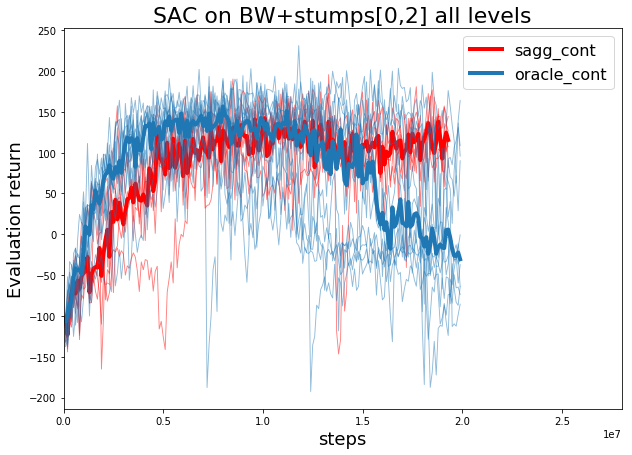

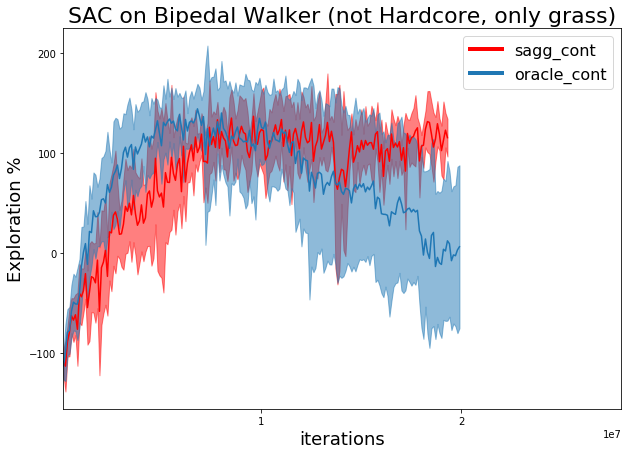

In [29]:
#OVERALL PERFS
plt.ion()
f, ax = plt.subplots(1,1,figsize=(10,7))
ax = [ax]
fm, axm = plt.subplots(1,1,figsize=(10,7))
axm = [axm]
for i,(m_id,d) in enumerate(models_saves.items()):
    print(m_id)
    runs_data = d['data']
    #print(len(runs_data))
    ys = []
    for run in runs_data:  
        #print(list(run))
        data = run['evaluation return']
        #data = run['AverageEpRet']
        #print(list(run))
        episodes = np.array(run['total timesteps'])
        print(run['config']['seed'])
        #print(len(run['env_params_train']))
        #print(len(run['env_params_test']))
        ys.append(data)
        #clean data    
        label = labels[m_id] if m_id in labels else m_id
    min_len = 999999
    for y in ys:
        if len(y) < min_len:
            min_len = len(y)
    ys_same_len = []
    for y in ys:
        ys_same_len.append(y[0:min_len])
    episodes = episodes[0:min_len]
    
    plot_all_and_median(0, ax[0], episodes,ys_same_len,colors[m_id],label,
                        title="SAC on BW+stumps[0,2] all levels", legend=True)
    #f.savefig('graphics/SAC_BW_stumps[0,2]_all_levels.png')
    plot_with_std(0, axm[0],episodes,np.mean(ys_same_len,axis=0),np.std(ys_same_len,axis=0),colors[m_id],colors[m_id],label,
                   legend=True, title="SAC on Bipedal Walker (not Hardcore, only grass)")

#get_welch(algo_0='sac_wstumpnoinputlvls_oracle4', algo_1='sagg_sac2')
        
#plt.savefig("graphics/sac_walker_small_vs_big_nets.png", bbox_inches='tight')

max:313.5665342608195 last:283.91133405856544
max:311.6019748464394 last:283.8093390038154
max:307.6374380660243 last:287.23524420502935
max:308.6080562448052 last:291.24004302588247
max:299.8434731741999 last:279.21589980702737
max:310.6703075407533 last:228.57811046496425
max:298.23420617565114 last:46.26383521765837
max:290.43805723325187 last:137.17116895137355
max:281.4471981640384 last:84.62389045828603
max:287.2617218657605 last:205.33663772964042
max:277.31391160100543 last:197.97645476602332
max:292.26033648044375 last:168.5285747982159
max:24.79880366401131 last:-84.28051264788326
max:-19.64092605312491 last:-68.86234258320192
max:31.906684375531018 last:-49.739978121530235
max:7.790279545187889 last:-64.10558923978441
max:5.484846206047502 last:-98.2661784208356
max:8.777296975357661 last:-55.98292536974242
max:305.5492487487444 last:244.64297284180526
max:291.108190292266 last:9.475436163154631
max:306.796620674483 last:-11.799092384987462
max:304.3656606440488 last:-65.124

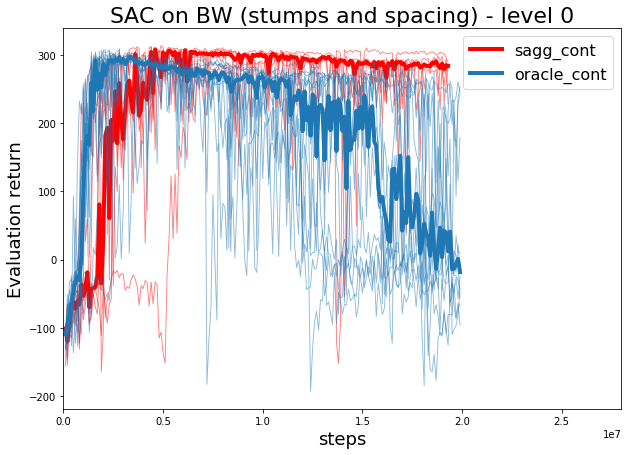

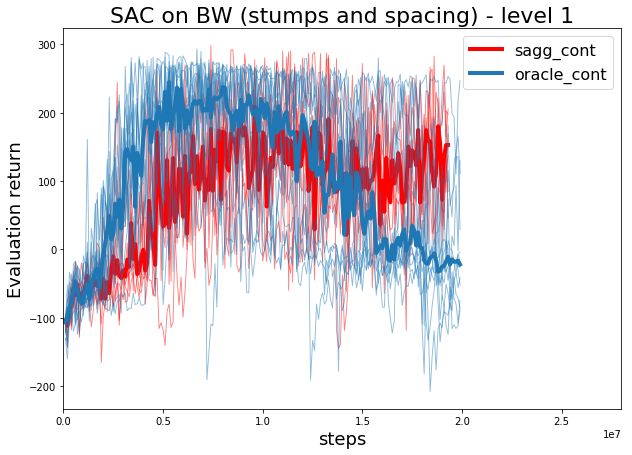

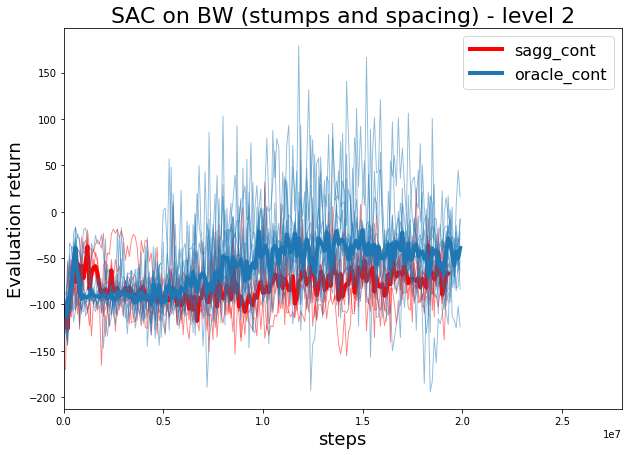

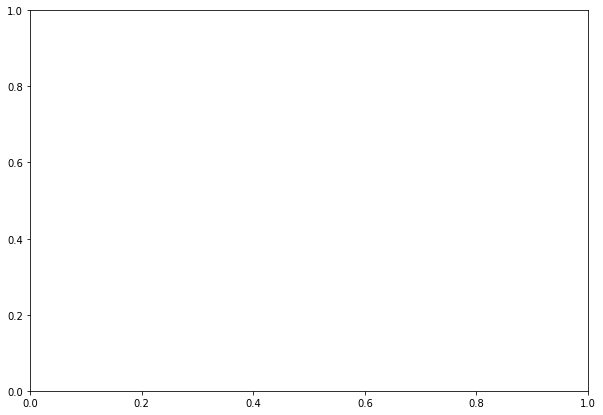

In [30]:
# LEVELS PERFS
nb_levels = 3
nb_tests_per_epochs = 15
level_step = int(nb_tests_per_epochs / nb_levels)
def get_level_ys(runs_data, min_len):
    level_ys = {}
    for i in range(nb_levels):
        level_ys[str(i)] = []
    nb_tests = len(runs_data[0]['env_test_rewards'][0:min_len*nb_tests_per_epochs])
    nb_steps = nb_tests/nb_tests_per_epochs
    steps = np.arange(0,nb_tests,nb_tests_per_epochs)
    #collect raw perfs
    for run in runs_data:
        raw_y = run['env_test_rewards'][0:min_len*nb_tests_per_epochs]
        level_y = {}
        for i in range(nb_levels):
            level_y[str(i)] = []
        for j in steps:
            #print(j)
            test_batch = raw_y[j:j+nb_tests_per_epochs]
            #print(test_batch)
            last_idx = 0
            for i in range(nb_levels):
                level_y[str(i)].append(np.mean(test_batch[last_idx:last_idx+level_step]))
                last_idx = last_idx+level_step
        for k in level_ys.keys():
            level_ys[k].append(level_y[k])
                
    return level_ys
    
    
f0, ax0 = plt.subplots(1,1,figsize=(10,7))
f1, ax1 = plt.subplots(1,1,figsize=(10,7))
f2, ax2 = plt.subplots(1,1,figsize=(10,7))
ax = [ax0,ax1,ax2]
fm, axm = plt.subplots(1,1,figsize=(10,7))
axm = [axm]
for i,(m_id,d) in enumerate(models_saves.items()):
    runs_data = d['data']
    ys = []
    for run in runs_data:  
        data = run['evaluation return']
        episodes = np.array(run['total timesteps'])
        ys.append(data) 
    #clean data   
    min_len = 999999
    for y in ys:
        if len(y) < min_len:
            min_len = len(y)
    ys_same_len = []
    for y in ys:
        ys_same_len.append(y[0:min_len])
    episodes = episodes[0:min_len]
    level_ys = get_level_ys(runs_data, min_len)
    #print(len(ys0[0]))
    #print(len(episodes))
    label = labels[m_id] if m_id in labels else m_id
    for k,lvl_ys in level_ys.items():
            plot_all_and_median(0, ax[int(k)], episodes,lvl_ys,colors[m_id],label=label,
                                title="SAC on BW (stumps and spacing) - level "+k, legend=True)
f0.savefig('graphics/SAC_BW_stumps[0,2]_level0.png')
f1.savefig('graphics/SAC_BW_stumps[0,2]_level1.png')
f2.savefig('graphics/SAC_BW_stumps[0,2]_level2.png')
    
#             plot_with_std(0, ax[int(k)],episodes,np.mean(lvl_ys,axis=0),np.std(lvl_ys,axis=0),colors[m_id],colors[m_id],label,
#                            legend=True, title="SAC on Bipedal Walker (not Hardcore, only grass)")


In [8]:
from param_env_utils.active_goal_sampling import SAGG_RIAC
import matplotlib.patches as patches
from param_env_utils.imgep_utils.gep_utils import scale_vector
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.colorbar as cbar

def scatter_plot_gif(data,nb_steps=50, name='test', xlim=None, ylim=None, fs=(7,7)):
    plt.ioff()
    length = len(data)
    step_size = int(length / nb_steps)
    print("Making an exploration GIF of {} steps".format(nb_steps))
    filenames = []
    for i,max_episodes in enumerate(np.arange(step_size,length+step_size,step_size)):
        scatter_plot(data[0:max_episodes],
                     emph_data=data[max_episodes-step_size:max_episodes],
                     xlim=xlim, ylim=ylim, fs=fs)
        f_name = "graphics/gifs/scatter_{}.png".format(i)
        plt.xlim(xmin=xlim[0],xmax=xlim[1])
        plt.ylim(ymin=ylim[0],ymax=ylim[1])
        plt.savefig(f_name, bbox_inches='tight')
        plt.close(f)
        filenames.append(f_name)
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/scatter_gif_{}.gif'.format(name), images, duration=0.3)


        
def scatter_plot(data, ax=None, emph_data=None, xlim=[0,2], ylim=[0,2],fs=(7,7)):
    #print(ylim)
    if ax is None:
        f, ax = plt.subplots(1,1,figsize=fs)
    Xs,Ys = [d[0] for d in data], [d[1] for d in data]
    if emph_data is not None:
        emphXs,emphYs = [d[0] for d in emph_data], [d[1] for d in emph_data]
    ax.plot(Xs,Ys,'r.',markersize=2)
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(ymin=ylim[0],ymax=ylim[1])
    ax.axis('equal')
    if emph_data is not None:
        ax.plot(emphXs,emphYs,'b.',markersize=5)
    ax.set_xlabel('stump height', fontsize=20)
    ax.set_ylabel('spacing', fontsize=20)
        
def plot_regions(boxes, interests, ax=None, xlim=[0,2], ylim=[0,2]):
    # Create figure and axes
    if ax==None:             
        f, ax = plt.gca()
    # Add the patch to the Axes
    for b,ints in zip(boxes,interests):
        #print(b)
        lx,ly = b.low
        hx,hy = b.high
        c = plt.cm.jet(ints)
        rect = patches.Rectangle([lx,ly],(hx - lx),(hy - ly),linewidth=3,edgecolor='white',facecolor=c)
        ax.add_patch(rect)
        #plt.Rectangle([lx,ly],(hx - lx), (hy - ly))

    cax, _ = cbar.make_axes(ax) 
    cb = cbar.ColorbarBase(cax, cmap=plt.cm.jet) 
    cb.set_label('Mean Competence Progress')
    ax.set_xlim(xmin=xlim[0],xmax=xlim[1])
    ax.set_ylim(ymin=ylim[0],ymax=ylim[1])
    ax.axis('equal')
    ax.set_xlabel('stump height', fontsize=20)
    ax.set_ylabel('stump_spacing', fontsize=20)

def region_plot_gif(all_boxes, interests, iterations, goals,
                    gifname='saggriac', rewards=None, ep_len=None,
                    xlim=[0,2], ylim=[0,2], fs=(27,7), plot_step=250):
    plt.ioff()
    print("Making an exploration GIF: "+gifname)
    filenames = []
    images = []
    steps = []
    mean_rewards = []
    for i in range(len(goals)):
        if i>0 and (i%plot_step == 0):
            f, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=fs)
            ax = [ax0,ax1, ax2]
            scatter_plot(goals[0:i], ax=ax[0], emph_data=goals[i-plot_step:i], xlim=xlim, ylim=ylim)
            idx = 0
            cur_idx = 0
            for j in range(len(all_boxes)):
                if iterations[j] > i:
                    break
                else:
                    cur_idx = j

            #ADD TRAINING CURVE
            ax[2].set_ylabel('Train return', fontsize=18)
            steps.append(sum(ep_len[0:i]))
            mean_rewards.append(np.mean(rewards[i-plot_step:i]))
            ax[2].plot(steps,mean_rewards)
            
            plot_regions(all_boxes[cur_idx], interests[cur_idx],ax=ax[1], xlim=xlim, ylim=ylim)
            f_name = "graphics/gifs/scatter_{}.png".format(i)
            plt.suptitle('Episode {}'.format(i), fontsize=20)
            plt.savefig(f_name, bbox_inches='tight')
            plt.close(f)
            filenames.append(f_name)
    for filename in filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('graphics/{}.gif'.format(gifname), images, duration=0.3)

def extract_env_params(env_goals, order):
    #order = ['stump_hs', 'tunnel_hs']
    flat_env_params = copy.copy(env_goals[order[0]])
    nb_episodes = len(flat_env_params)
    if len(order) == 1:
        pass #work already done
    elif order == ['stump_hs', 'ob_sps']:
        for ep_nb in range(nb_episodes):
                flat_env_params[ep_nb][1] = env_goals['ob_sps'][ep_nb] #ignore variance 
    elif len(order) == 2:
        for ep_nb in range(nb_episodes):
            for i in range(1,len(order)):
                flat_env_params[ep_nb][1] = env_goals[order[i]][ep_nb][0] #ignore variance 
        print(env_goals[order[0]][0])
        print(env_goals[order[1]][1])
        print(flat_env_params[0])
    return flat_env_params

sagg_cont
[1.596828579902649, 3.3108129501342773]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
50
['stump_hs', 'ob_sps']


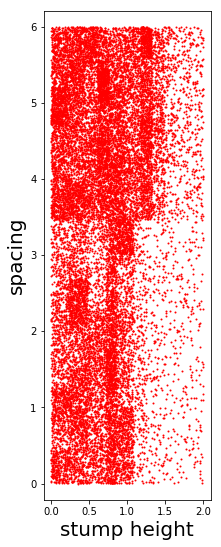

[0.6300771832466125, 5.181125640869141]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
30
['stump_hs', 'ob_sps']


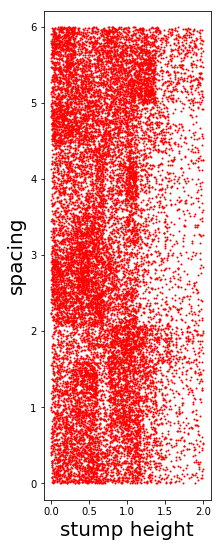

[0.2627735733985901, 2.7470717430114746]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
40
['stump_hs', 'ob_sps']


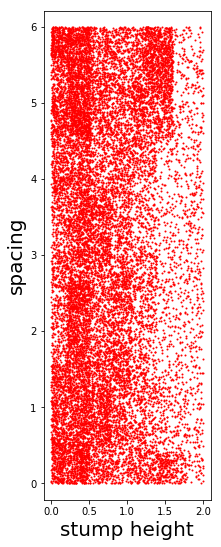

[0.7164592742919922, 2.2748467922210693]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
0
['stump_hs', 'ob_sps']


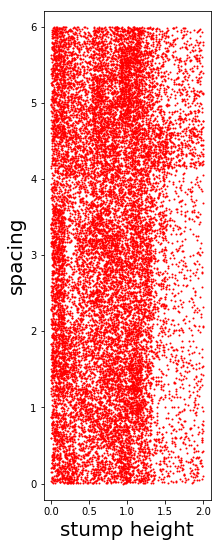

[0.11404392868280411, 2.28902530670166]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
10
['stump_hs', 'ob_sps']


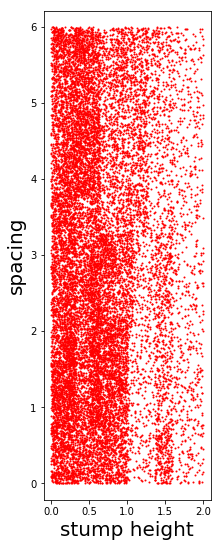

[0.28841978311538696, 3.9741580486297607]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
20
['stump_hs', 'ob_sps']


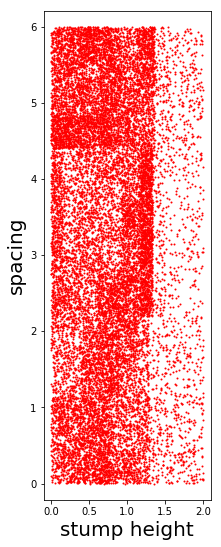

oracle_cont
[0.12425506371886497, 5.4109408029965405]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
33
['stump_hs', 'ob_sps']


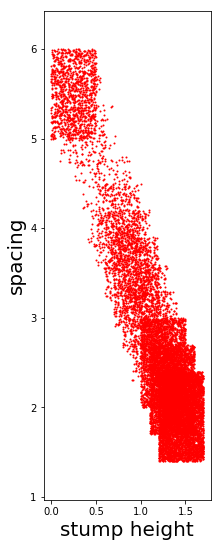

[0.046554143335929, 5.483859980463646]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
55
['stump_hs', 'ob_sps']


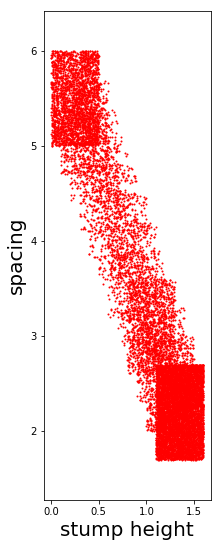

[0.385660321633373, 5.633648234926276]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
10
['stump_hs', 'ob_sps']


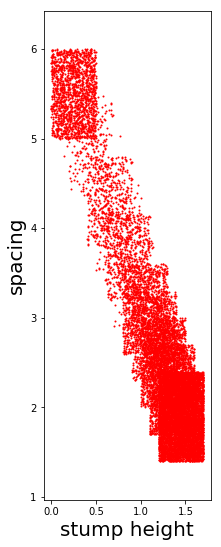

[0.3220717680341675, 5.663047905335668]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
30
['stump_hs', 'ob_sps']


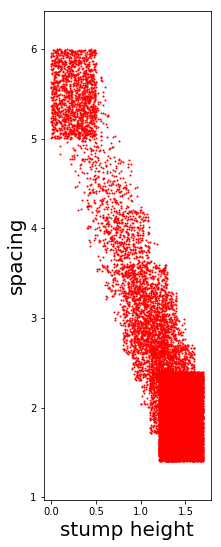

[0.0901348444383846, 5.463218526498345]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
11
['stump_hs', 'ob_sps']


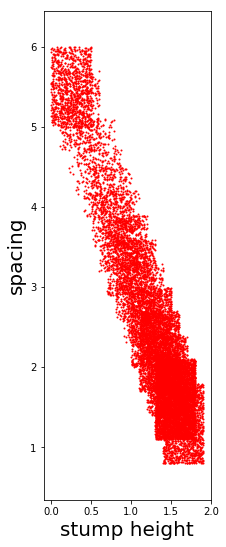

[0.07708142118983619, 5.2633150151851344]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
12
['stump_hs', 'ob_sps']


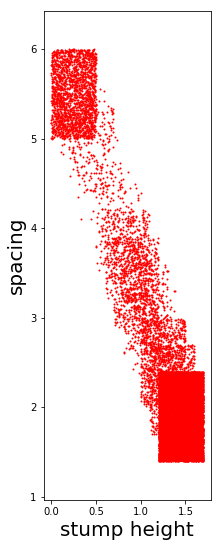

[0.24730082276901072, 5.2554739237572115]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
50
['stump_hs', 'ob_sps']


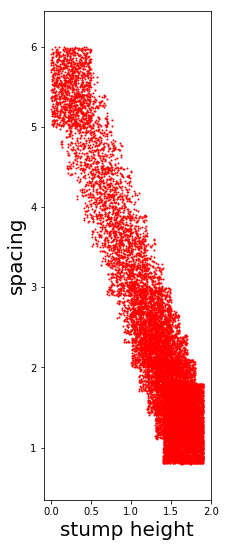

[0.2744067519636624, 5.6027633760716435]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
0
['stump_hs', 'ob_sps']


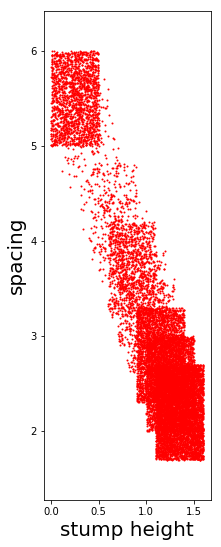

[0.3888512052869101, 5.824278532661369]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
13
['stump_hs', 'ob_sps']


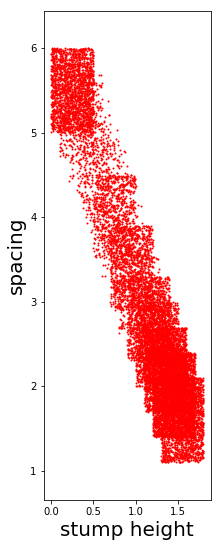

[0.20384351404014306, 5.788534877486753]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
40
['stump_hs', 'ob_sps']


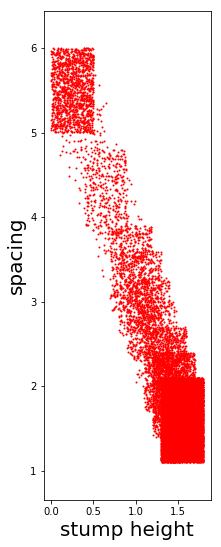

[0.2940654005386371, 5.891530729474708]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
20
['stump_hs', 'ob_sps']


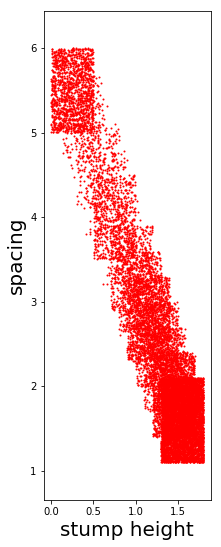

[0.4174210743328247, 5.744640481679518]
None
dict_keys(['stump_hs', 'tunnel_hs', 'ob_sps'])
44
['stump_hs', 'ob_sps']


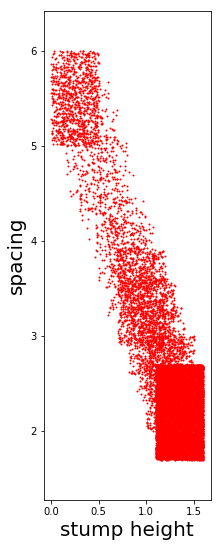

In [14]:
#PLOT scatter plots
for i,(m_id,d) in enumerate(models_saves.items()):
    print(m_id)
    runs_data = d['data']

    for j,run in enumerate(runs_data):
        #print(j)
        d = run['env_params_train']
        print(d['stump_hs'][0])
        print(d['tunnel_hs'][0])
        print(d.keys())
        print(run['config']['seed'])
        order = []
        if d['stump_hs'][0]:
            order.append('stump_hs')
        if d['tunnel_hs'][0]:
            order.append('tunnel_hs')
        if d['ob_sps'][0]:
            order.append('ob_sps')
        print(order)
        
        scatter_plot(extract_env_params(d, order), xlim=[0,2], ylim=[0,6], fs=(3,9))
        plt.show()
            
#         scatter_plot_gif(extract_env_params(d, order),
#                           name='{}{}'.format(m_id, j), xlim=[0,2], ylim=[0,6])


In [ ]:
import importlib
import param_env_utils.active_goal_sampling as gsamp
importlib.reload(gsamp)
#Testing sagg_iac
print(list(models_saves))
data = models_saves['sac_lgwidestumpnoinputlevels']['data'][5]
print(len(data['env_params_train']))
print(len(data['env_train_rewards']))
env_goals = data['env_params_train']
reward_outcome = data['env_train_rewards']
#scatter_plot(env_goals)
ndims = 2
SAGG = gsamp.SAGG_RIAC(np.array([0.0]*ndims), np.array([2.0]*ndims))
all_boxes = []
iterations = []
interests = []
plot = False
for i,(g,o) in enumerate(zip(env_goals,reward_outcome)):
    split, _ = SAGG.update([np.array(g)], None, continuous_competence=[np.interp(o, (-200, 300), (0,1))])
    if split:
        boxes = SAGG.region_bounds
        interest = SAGG.interest
        if plot:
            plot_regions(boxes, interest)
            plt.show()
        interests.append(copy.copy(interest))
        iterations.append(i)
        all_boxes.append(copy.copy(boxes))

In [11]:
#scatter_plot(env_goals)
print(list(models_saves))
sagg_model_name = 'sagg_cont'
#print(models_saves[sagg_model_name]['data'][0]['config']['seed'])
for i in range(len(models_saves[sagg_model_name]['data'])):
    all_boxes = models_saves[sagg_model_name]['data'][i]['all_boxes']
    split_iterations = models_saves[sagg_model_name]['data'][i]['split_iterations']
    env_train_rewards = models_saves[sagg_model_name]['data'][i]['env_train_rewards']
    all_interests = models_saves[sagg_model_name]['data'][i]['all_interests']
    env_goals = models_saves[sagg_model_name]['data'][i]['env_params_train']
    ep_len = models_saves[sagg_model_name]['data'][i]['env_train_len']
    print(list(env_goals))
    #print(env_goals['stump_hs'][0])
    order = []
    if env_goals['stump_hs'][0]:
        order.append('stump_hs')
    if env_goals['tunnel_hs'][0]:
        order.append('tunnel_hs')
    if env_goals['ob_sps'][0]:
        order.append('ob_sps')
    if len(env_goals) >= 2:
        env_goals = extract_env_params(env_goals, order)
        print(len(env_goals))
        
    if len(all_boxes) == 0:
        print('abort {}'.format(i))
        continue
    print(len(env_goals))
    region_plot_gif(all_boxes, all_interests, split_iterations, env_goals,
                   gifname='onlineSAGG'+str(i), rewards=env_train_rewards,
                    ep_len=ep_len, xlim=[0,2], ylim=[0,6], fs=(12,9),
                   plot_step = 500)

['sagg_cont', 'oracle_cont']
['stump_hs', 'tunnel_hs', 'ob_sps']
20959
20959
Making an exploration GIF: onlineSAGG0
['stump_hs', 'tunnel_hs', 'ob_sps']
18304
18304
Making an exploration GIF: onlineSAGG1
['stump_hs', 'tunnel_hs', 'ob_sps']
18671
18671
Making an exploration GIF: onlineSAGG2
['stump_hs', 'tunnel_hs', 'ob_sps']
17439
17439
Making an exploration GIF: onlineSAGG3
['stump_hs', 'tunnel_hs', 'ob_sps']
17284
17284
Making an exploration GIF: onlineSAGG4
['stump_hs', 'tunnel_hs', 'ob_sps']
18586
18586
Making an exploration GIF: onlineSAGG5


![](graphics/exploration0.gif)
![](graphics/exploration1.gif)


![SegmentLocal](graphics/onlineSAGG0.gif "competence")
![SegmentLocal](graphics/onlineSAGG1.gif "competence")
![SegmentLocal](graphics/onlineSAGG2.gif "competence")
![SegmentLocal](graphics/onlineSAGG3.gif "competence")
![SegmentLocal](graphics/onlineSAGG4.gif "competence")
![SegmentLocal](graphics/onlineSAGG5.gif "competence")

In [ ]:
lidar = []
self.lidar[i].fraction = 1.0
            self.lidar[i].p1 = pos
            self.lidar[i].p2 = (
                pos[0] + math.sin(1.5*i/10.0)*LIDAR_RANGE,
                pos[1] - math.cos(1.5*i/10.0)*LIDAR_RANGE)

In [ ]:
metrics_mean_explo = [mean_a_explo, mean_p_explo, mean_s_explo, mean_b_explo, mean_c_explo] 
metrics_std_explo = [std_a_explo, std_p_explo, std_s_explo, std_b_explo, std_c_explo]
plot_steps = np.arange(0,nb_episodes+step_size,step_size)
colors = ['red','blue','green','magenta','black','cyan','orange']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
title_info = ["agent", "pickaxe", "shovel", "blocks", "cart"]
model_names = titles
metric = ["agent","pickaxe","shovel","blocks","cart"]
maxes=[85,85,85,100,85]

# # Averaged plots
# f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5,figsize=(20,4))
# ax = (ax0, ax1, ax2, ax3, ax4)
# print(model_filenames)
# for j, (models_mean_explo, models_std_explo) in enumerate(zip(metrics_mean_explo, metrics_std_explo)):
#     for i,(mean_explo, std_explo) in enumerate(zip(models_mean_explo, models_std_explo)):
#         y = mean_explo
#         err = std_explo
#         title = ''
#         plot_with_std(j, ax[j], plot_steps,y,err,colors[i],shades_colors[i],model_names[i],
#                       y_min=0,y_max=maxes[j], title=title+title_info[j], legend=True)
        
# #plt.savefig("graphics/grid_cell_exploration_mmc.pdf", bbox_inches='tight')
# #plt.savefig("grid_cell_exploration_samebt.png", bbox_inches='tight')
# plt.show()

#PLOT ALL + MEDIAN
all_explo = [all_a_explo, all_p_explo, all_s_explo, all_b_explo, all_c_explo]
f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1,5,figsize=(20,4))
ax = (ax0, ax1, ax2, ax3, ax4)
print(model_filenames)
for j, models_all_explo in enumerate(all_explo):
    for i, explo in enumerate(models_all_explo):
        ys = explo
        title = ''
        plot_all_and_median(j, ax[j], plot_steps,ys,colors[i],shades_colors[i],model_names[i],
                      y_min=0,y_max=maxes[j], title=title+title_info[j], legend=True)
plt.savefig("graphics/grid_cell_exploration_mmc.png", bbox_inches='tight')


In [ ]:
def plot_with_std(x,y,err,color,shade_color,label,y_min,y_max):
    plt.plot(x,y, color=color, label=label,linewidth=1.5)
    plt.fill_between(x,y-err,y+err,color=shade_color,alpha=0.5)
    leg = plt.legend(loc='lower right')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
    plt.xlabel('episodes')
    plt.ylabel('exploration %')
    if y_min is not None:
        plt.ylim(ymin=y_min,ymax=y_max)
    

labels = ['RND','F-RGB','RMB','AMB']
shades_colors = ['lightsalmon','skyblue','lightgreen','violet']
print("agent exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_a_explo[i,-1])
    y = mean_a_explo[i,:]
    err = std_a_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("shovel exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_s_explo[i,-1])
    y = mean_s_explo[i,:]
    err = std_s_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("pickaxe exploration")
x = np.arange(0,nb_episodes+step_size,step_size)
for i in range(nb_models):
    print(std_p_explo[i,-1])
    y = mean_p_explo[i,:]
    err = std_p_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_agent_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("cart")
for i in range(nb_models):
    print(std_c_explo[i,-1])
    y = mean_c_explo[i,:]
    err = std_c_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_cart_pos_expl.pdf", bbox_inches='tight')
plt.show()

print("blocks")
for i in range(nb_models):
    y = mean_b_explo[i,:]
    err = std_b_explo[i,:]
    plot_with_std(x,y,err,colors[i],shades_colors[i],labels[i],0,100)
#plt.savefig("dist_bread_pos_expl.pdf", bbox_inches='tight')
plt.show()
#plt.plot(mean_a_explo, color='red', label=m_name.replace('_',' '))
#plt.plot(mean_c_explo, color='blue', label=m_name.replace('_',' '))
#plt.plot(mean_b_explo, color='green', label=m_name.replace('_',' '))
        

In [ ]:
def plot_interests(ax,subplot_nb,interest_dict, legend=True, labels=None):
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    colors = ['red','blue','green','magenta','black',
              'cyan','orange','powderblue','salmon','aqua','darkolivegreen',
             'orchid','indigo','saddlebrown']
    for i,(name,interests) in enumerate(sorted(interest_dict.items())):
        #print(name)
        if labels is not None:
            ax.plot(interests, color=colors[i], label=labels[i],linewidth=1.5)
        else:
            ax.plot(interests, color=colors[i], label=name.replace('_',' '),linewidth=1.5)
    if subplot_nb == 0:
        ax.set_ylabel('Interest', fontsize=18)
        
    ax.set_xlabel('Iterations', fontsize=18)
    if legend:
        leg = ax.legend(loc='upper left')
        for legobj in leg.legendHandles:
            legobj.set_linewidth(4.0)

short_labels = ['agent','bread','cart','distr 1','distr 2','distr 3', 'distr 4']

# Plot interest curves:

for i in range(9):
    f, (ax0, ax1) = plt.subplots(1,2,figsize=(16,4))
    ax = (ax0, ax1)
    ints = saves[model_filenames[2]][i]['interests']
    plot_interests(ax[0],0,ints,legend=True,labels=None)
#plt.savefig("aaa_newold_interests_samebt.png", bbox_inches='tight')




In [ ]:
# PLOT 3 SAMPLES OF AMB INTERESTS
f, (ax0, ax1, ax2) = plt.subplots(1,3,figsize=(24,4))
ax = (ax0, ax1, ax2)
for i,run_nb in enumerate([0,3,8]):
    ints = saves[model_filenames[2]][run_nb]['interests']
    plot_interests(ax[i],i,ints,legend=True,labels=None)
plt.savefig("graphics/interest_curves_amb_mmc.png", bbox_inches='tight')


In [ ]:
# Plot competence evolution for amb runs
f, (ax0, ax1) = plt.subplots(1,2,figsize=(20,4))
ax = (ax0, ax1)
m_names = ['pickaxe_end_pos']

for i in range(1):
    dists = {}
    for m_name in m_names:
        
        all_goals = saves[model_filenames[2]][1]['modules'][m_name].generated_goals
        all_outs = saves[model_filenames[2]][1]['modules'][m_name].observed_outcomes
        print(len(all_goals))
        print(len(all_outs))
        goals = np.array([all_goals[k-1] for k in range(5,len(all_goals),5)])
        outs = np.array([all_outs[k-1] for k in range(5,len(all_outs),5)])
        print(goals[-5:])
        print(outs[-5:])
        d = np.linalg.norm(goals - outs,axis=1)
        dists[m_name] = d
    #euc_d2 = np.linalg.norm(goals - outs,axis=1)
#     print(goals[0:3])
#     print(outs[0:3])
#     print(dists[0:3])
#     print(euc_d[0:3])
#     print(euc_d2[0:3])
#     print("h")
    plot_interests(ax[i],i,dists,legend=False,labels=None)

In [ ]:
# get interest curves names:
labels_2 = [s.replace('_',' ') for s in np.unique(saves[model_filenames[3]][0]['choosen_modules'])]

#labels = ['agent final position','bread final count','cart final position',
#               'fixed distractor 1 final position','fixed distractor 2 final position','moving distractor 1 final position', 'moving distractor 2 final position']
colors = ['red','blue','green','magenta','black','cyan','orange']

fig = pylab.figure()
figlegend = pylab.figure(figsize=(3.5,2))
ax = fig.add_subplot(111)
line_data = []
#for i in range(len(labels)):
#    line_data.append([range(10), pylab.randn(10), colors[i]])
print(len(labels_2))
if len(labels_2) == 3:
    lines = ax.plot(range(10),pylab.randn(10),colors[0],
                    range(10),pylab.randn(10),colors[1],
                    range(10),pylab.randn(10),colors[2])
elif len(labels_2) == 5:
    lines = ax.plot(range(10),pylab.randn(10),colors[0],
                    range(10),pylab.randn(10),colors[1],
                    range(10),pylab.randn(10),colors[2],
                    range(10),pylab.randn(10),colors[3],
                    range(10),pylab.randn(10),colors[4])
    
leg = figlegend.legend(lines, labels_2[:len(labels_2)], 'center')
for legobj in leg.legendHandles:
            legobj.set_linewidth(6.0)
        
figlegend.show()
figlegend.savefig('legend.png')

In [ ]:
# Time complexity analysis
for m_name, m_id in zip(model_full_names,model_filenames):
    print(m_id)
    b_k = saves[m_id][4]
    if 'runtimes' in b_k:
        rts = b_k['runtimes']
        #print(rts['produce'][-100:])
        plt.plot(rts['produce'],label='choose policy')
        plt.plot(rts['run'],label='run episode')
        plt.plot(rts['perceive'],label='add to memory')
        plt.legend()
        plt.ylabel('seconds')
        plt.xlabel('episodes')
    plt.savefig("time_complexity.png")
    plt.show()


In [ ]:
Xs,Ys = [],[]
plt.figure()
epsilon = 1e-3
for i in range(500):
    random_stump_height = (np.random.random(2) * 2.0)
    random_stump_height.sort()
    if np.abs(random_stump_height[1] - random_stump_height[0]) < epsilon:
        random_stump_height[1] += epsilon
    Xs.append(random_stump_height[0])
    Ys.append(random_stump_height[1])
plt.plot(Xs,Ys,'r.')
plt.axis('equal')
plt.show()

Xs,Ys = [],[]
plt.figure()
epsilon = 1e-3
for i in range(500):
    min_stump_height = np.random.uniform(0,2.0)
    max_stump_height = np.random.uniform(min_stump_height,2.0)
    Xs.append(min_stump_height)
    Ys.append(max_stump_height)
plt.plot(Xs,Ys,'r.')
plt.axis('equal')
plt.show()

In [ ]:
a = []
a.append([1,3])
a.append([1,2])
print(len(a))